## Final Project Submission

Please fill out:
* Student name: Benjamin Atkin
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Abhineet Kulkarni
* Blog post URL: 


# Introduction

The goal of this project is to create 2 machine learning models that can predict how long a rental will remain vacant on the market. These models can then inform rental management companies' marketing strategies, potentially telling them when to reduce the price, by how much and which of the properties in their portfolio will rent most quickly.

The data I used includes daily advertised rents and property specs that were scraped by my automated scrapers between 07-06-2018 and 12-09-2019 (~28 million rows representing daily rental information for ~1.3 million unique rental addresses).

    The target we're trying to predict:

        Will a rental take more than 15 days to rent?

    Predictor features:
        initial rent price
        days until first price reduction
        first change amount
        total price reduction amount
        total number of times price was reduced
        land_use
        acres
        sqft_total
        bedroom_count
        bathroom_count
        total_value


# Notebook setup

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# Extract data from Postgres and transform

For the sake of documentation I'll copy the SQL script I used to extract the data from my Postgres database. The original dataset is in such a format that every row corresponds to a single day's observation of a rental's info. That means that there are many rows (each row represents a day I scraped) that correspond to a single rental. I needed to group all these daily rental observations into one row per rental that had all the information about price changes.

In [ ]:
# Create temporary table that forms the basis of our dataset, uses window function over parcel_id 
# to compare rental info over multiple days. Each row of this vac_temp table is a unique rent price
# and shows how long a rental was listed at that price.
select
    row_number() over parcel_w,
    lead(min(scrape_date)) over parcel_w - min(scrape_date) as days_to_change,
    lead(rent) over parcel_w - rent as change_amt,
    count(distinct scrape_date) as days_at_curr_rent,
    min(scrape_date) as min_sc,
    max(scrape_date) as max_sc,
    rent,
    parcel_id
into temp table vac_temp
from vacancy
where
 parcel_id is not null
    and source = 'appfolio'
    and scrape_date between '2019-01-01' and '2019-10-01'
group by rent, parcel_id
WINDOW parcel_w as (
    partition by parcel_id
    order by parcel_id, min(scrape_date));

# Create another temporary table that aggregates all information that can't be obtained with window
# function.
select
    parcel_id,
    count(*) - 1 as num_changes,
    sum(change_amt) as tot_rent_change,
    sum(days_at_curr_rent) as total_days_on_market
into temp table aggs
from vac_temp
group by parcel_id;


# The following SELECT INTO statements could be replaced by one CREATE TABLE and then subsequent 
# UPDATE statements but this approach (creating temporary tables and joining at the end) works fine 
# even though it's a bit verbose.

# Create temporary table that represents the first price change. Will be joined at end.
select
    parcel_id,
    rent           as initial_rent,
    days_to_change as days_til_first_change,
    change_amt     as first_change_amt
into temp table first_row
from vac_temp
where row_number = 1;

# Create temporary table that represents the second price change. Will be joined at end.
select
    parcel_id,
    days_to_change as days_til_second_change,
    change_amt as second_change_amt
into temp table second_row
from vac_temp
where row_number = 2;

# Create temporary table that represents the third price change. Will be joined at end.
select
    parcel_id,
    days_to_change as days_til_third_change,
    change_amt as third_change_amt
into temp table third_row
from vac_temp
where row_number = 3;

# Create temporary table that represents the fourth price change. Will be joined at end.
select
    parcel_id,
    days_to_change as days_til_fourth_change,
    change_amt as fourth_change_amt
into temp table fourth_row
from vac_temp
where row_number = 4;

# Create temporary table that represents the fifth price change. Will be joined at end.
select
    parcel_id,
    days_to_change as days_til_fifth_change,
    change_amt as fifth_change_amt
into temp table fifth_row
from vac_temp
where row_number = 5;

# Select final dataset with all joins.
select
    aggs.*,
    first_row.initial_rent,
    first_row.days_til_first_change,
    first_row.first_change_amt,
    second_row.days_til_second_change,
    second_row.second_change_amt,
    third_row.days_til_third_change,
    third_row.third_change_amt,
    fourth_row.days_til_fourth_change,
    fourth_row.fourth_change_amt,
    fifth_row.days_til_fifth_change,
    fifth_row.fifth_change_amt,
    parcel_number,
    parcel_county,
    parcel_address1,
    parcel_address2,
    parcel_city,
    parcel_state,
    parcel_zipcode,
    parcel_longitude,
    parcel_latitude,
    land_use,
    acres,
    sqft_total,
    bedroom_count,
    bathroom_count,
    year_built,
    last_sale,
    last_price,
    total_value
from first_row
    left join second_row using (parcel_id)
    left join third_row using (parcel_id)
    left join fourth_row using (parcel_id)
    left join fifth_row using (parcel_id)
    join aggs using (parcel_id)
    join jmb_parcel on first_row.parcel_id = jmb_parcel.id
    join jmb_identity on jmb_parcel.identity_id = jmb_identity.id;
    
# I used Pycharm's data extractor tool to export this query's output as 'rental_dataset' which is 
# available in the project's directory but a COPY statement could be used to achieve the same 
# result.

Now that we have our initial dataset, we will continue working in Pandas to make additional changes.

# Investigating the target variable

In [52]:
df = pd.read_csv('rental_dataset.csv')
df.head()

,parcel_id,num_changes,tot_rent_change,total_days_on_market,initial_rent,days_til_first_change,first_change_amt,days_til_second_change,second_change_amt,days_til_third_change,third_change_amt,days_til_fourth_change,fourth_change_amt,days_til_fifth_change,fifth_change_amt,parcel_number,parcel_county,parcel_address1,parcel_address2,parcel_city,parcel_state,parcel_zipcode,parcel_longitude,parcel_latitude,land_use,acres,sqft_total,bedroom_count,bathroom_count,year_built,last_sale,last_price,total_value
0,128,0,NaN,5,1150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12433719056,Clark,5036 TREASURE HILLS ST,NaN,NORTH LAS VEGAS,NV,89031.0,-115.154835,36.251780,386.0,0.080005,1421,3,2.0,2006.0,2015-08-31,128000,64311.0
1,227,0,NaN,8,1150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B-1958-0002-000B,Iron,257 E 3025 N,NaN,CEDAR CITY,UT,84721.0,-113.057423,37.731860,386.0,0.025000,0,0,0.0,NaN,NaN,0,92950.0
2,399,2,-100.0,24,1495.0,25.0,-50.0,6.0,-50.0,NaN,NaN,NaN,NaN,NaN,NaN,02149149,Washoe,4418 MATICH DR,NaN,RENO,NV,89502.0,-119.749263,39.475540,366.0,0.001010,1034,2,3.0,1985.0,2014-12-15,115000,30333.0
3,552,0,NaN,9,1495.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12427712035,Clark,5804 SIERRA CLIFF ST,NaN,NORTH LAS VEGAS,NV,89031.0,-115.139655,36.265633,385.0,0.110009,2039,2,3.0,2008.0,2013-05-20,130000,90942.0
4,631,0,NaN,16,1490.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12422811083,Clark,6461 RAVEN HALL ST,NaN,NORTH LAS VEGAS,NV,89084.0,-115.141522,36.277937,385.0,0.060009,1575,4,3.0,2004.0,2018-03-01,215000,69884.0


First off, let's take a look at the distribution of our target variable, total_days_on_market.

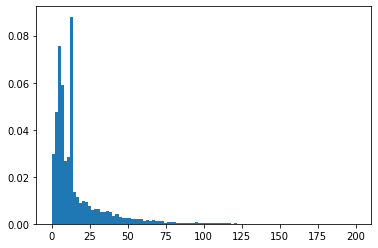

In [43]:
# Distribution of days_vacant across dataset
plt.hist(df.total_days_on_market, bins=100, density=True, range=(0, 200));

In [51]:
df.total_days_on_market.describe()

count    18773.000000
mean        15.846961
std         20.116350
min          1.000000
25%          5.000000
50%         10.000000
75%         17.000000
max        211.000000
Name: total_days_on_market, dtype: float64

Our dataset has a mean total_days_on_market of ~16 (15.8). Instead of trying to get an accurate prediction of how long a property will take to rent, I'll first create a binary classifier to tell us if a rental is going to be vacant for **more than 15 days**.

# Preprocess extracted data

# Create baseline Decision Tree classifier

Set max depth wild.

Print it out.

Then finally, use a Random Forest.

# Create baseline XgBoost classifier

Look at feature importance

optimize training data

What's not important, important

Final models using gridsearch

Score them compare them

conclusion

Spend time feature engineering

Visualization explaining 

Gain insights using model

Come to conclusions

Make bins based on histogram, avoid class imbalance problems otherwise I'll have to SMOTE

Investigate why a certain class gets misclassified if that happens

Investigate kfold cross validation.




Exec summary:

Could show decision tree

Feature importance, being able to explain feature importance

Graph of feature importances, model.feature_importances.


Regularization:
> 50 L1
<= 50 L2

